# SLMS

## Required Packages

In [ ]:
# !pip install -Uqqq pip --progress-bar off
# !pip install -qqq torch==2.1 --progress-bar off
# !pip install -qqq accelerate==0.23.0 --progress-bar off
# !pip install -qqq bitsandbytes==0.41.1 --progress-bar off
# !pip install langchain langchain_community
# !pip install langchainhub
# !pip install git+https://github.com/huggingface/transformers
# !wget https://www.plus2net.com/python/download/my_db.db

In [ ]:
# !pip install langchain_experimental

## Required Libraries

In [ ]:
from langchain import hub
from langchain_community.utilities import SQLDatabase

import sqlite3

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    TextStreamer,
    pipeline,
)

from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain

import pandas as pd

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


## SLM Model

In [ ]:
MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME , use_fast=False) # ,use_fast=False
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
        trust_remote_code=True,
        # torch_dtype=torch.bfloat16,
         load_in_8bit=True,
        device_map="auto",

)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 256
generation_config.temperature = 0.0001
generation_config.num_beams=1
generation_config.num_beam_groups=1
generation_config.do_sample = True


llm_pipeline = pipeline(
"text-generation",
model=model,
tokenizer=tokenizer,
return_full_text=True,
generation_config=generation_config,
num_return_sequences=1,
eos_token_id=tokenizer.eos_token_id,
pad_token_id=tokenizer.eos_token_id
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
template = """
### Task
Generate a PYTHON code to answer [QUESTION]{user_question}[/QUESTION]

### DataFrame
The python code will run on a following dataframe:
dataframe name : {dataframe name}
dataframe : {dataframe}

No need to import libraries ,
Use above dataframe name as the name of the dataframe .

### Answer
Given the dataframe, here is the PYTHON code that [QUESTION]{user_question}[/QUESTION]
[PYTHON]

"""
prompt = PromptTemplate(input_variables = ['user_question','dataframe','dataframe name'] , template = template )

llm_chain = LLMChain(llm = llm , prompt = prompt)

In [ ]:

db = SQLDatabase.from_uri("sqlite:///./my_db.db",sample_rows_in_table_info=0)
table_names = db.get_usable_table_names()
student_table = table_names[1]
connection = sqlite3.connect("my_db.db")
student = pd.read_sql("select * from student ;",connection)
question = "Plot the distribution of marks of student"
input = {'user_question':question , 'dataframe':[student] , "dataframe name":"student"}




In [ ]:
res = llm_chain.invoke(input)

In [ ]:
print(res['text'])

```python
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set_style("whitegrid")

# Create a histogram of the marks
plt.hist(student['mark'], bins=50)

# Set the title and labels of the plot
plt.title("Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")

# Show the plot
plt.show()
```

This code imports the necessary libraries `matplotlib.pyplot` and `seaborn`, sets the style of the plot using `seaborn.set_style()`, creates a histogram of the marks using `plt.hist()`, sets the title and labels of the plot using `plt.title()` and `plt.xlabel()` and `plt.ylabel()`, and finally shows the plot using `plt.show()`.


In [ ]:
s = res['text'].find("import")
e = res['text'].rfind('```')
python_text = res['text'][s:e]

In [ ]:
print(python_text)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set_style("whitegrid")

# Create a histogram of the marks
plt.hist(student['mark'], bins=50)

# Set the title and labels of the plot
plt.title("Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")

# Show the plot
plt.show()



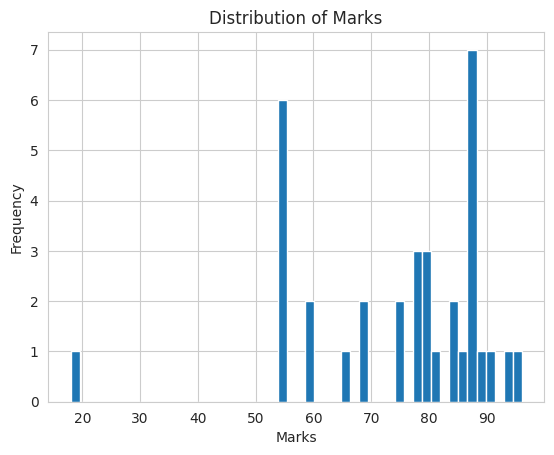

In [ ]:
exec(python_text)